## 1 Import Libraries and Data

In [72]:
import os
from tkinter.constants import FIRST

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from pytz.exceptions import NonExistentTimeError
from tornado.autoreload import watch

# import Dataframes with cleaned data independently of the operating system (mac or windows or linux) in a pandas dataframe
charging_data = pd.read_pickle(os.path.join('Data', 'charging_data.pkl'))
weather_data = pd.read_pickle(os.path.join('Data', 'weather_data.pkl'))

In [73]:
# charging_data.head()
print(charging_data.columns)
# weather_data.head()
charging_data.head()


Index(['counter', 'id', 'connectionTime', 'disconnectTime', 'doneChargingTime',
       'kWhDelivered', 'sessionID', 'siteID', 'spaceID', 'stationID',
       'timezone', 'userID', 'userInputs', 'connection_date',
       'charging_duration', 'connection_duration'],
      dtype='object')


,counter,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs,connection_date,charging_duration,connection_duration
0,0,5e23b149f9af8b5fe4b973cf,2020-01-02 05:08:54-08:00,2020-01-02 11:11:15-08:00,2020-01-02 09:31:35-08:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,America/Los_Angeles,194,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil...",2020-01-02,262.683333,362.350000
1,1,5e23b149f9af8b5fe4b973d0,2020-01-02 05:36:50-08:00,2020-01-02 14:38:21-08:00,2020-01-02 12:18:05-08:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,America/Los_Angeles,4275,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil...",2020-01-02,401.250000,541.516667
2,2,5e23b149f9af8b5fe4b973d1,2020-01-02 05:56:35-08:00,2020-01-02 16:39:22-08:00,2020-01-02 08:35:06-08:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,America/Los_Angeles,344,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",2020-01-02,158.516667,642.783333
3,3,5e23b149f9af8b5fe4b973d2,2020-01-02 05:59:58-08:00,2020-01-02 08:38:39-08:00,2020-01-02 07:18:45-08:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,America/Los_Angeles,1117,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",2020-01-02,78.783333,158.683333
4,4,5e23b149f9af8b5fe4b973d3,2020-01-02 06:00:01-08:00,2020-01-02 14:08:40-08:00,2020-01-02 10:17:30-08:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,America/Los_Angeles,334,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil...",2020-01-02,257.483333,488.650000


## 2 Descriptive Analysis

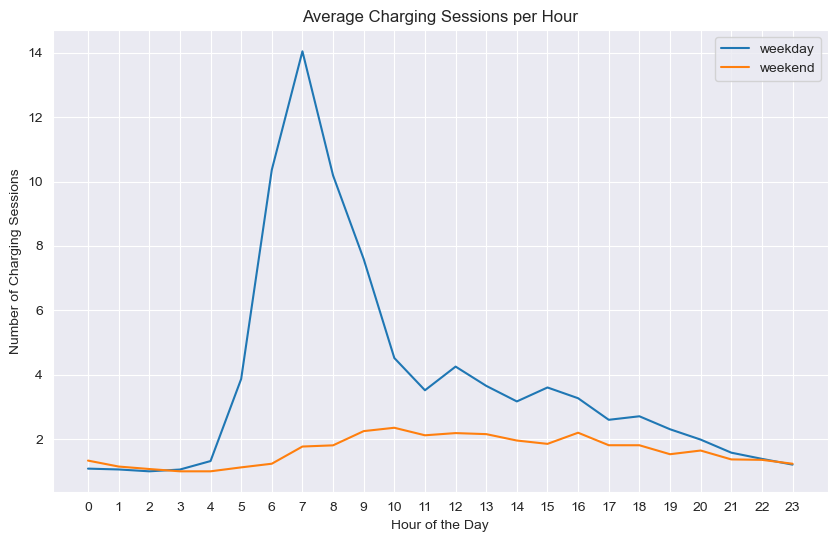

In [74]:
charging_data["day"] = charging_data["connectionTime"].dt.day_name()
charging_data['isWeekend'] = charging_data['day'].isin(['Saturday', 'Sunday'])
charging_data["hour"] = charging_data["connectionTime"].dt.hour
charging_data["date"] = charging_data["connectionTime"].dt.date

# calculate number of charging sessions per day and hour
sessions_per_hour_day_weekend = charging_data[charging_data['isWeekend']].groupby(["date", "hour"]).size().reset_index(
    name="count")
sessions_per_day_weekday = charging_data[~charging_data['isWeekend']].groupby(["date", "hour"]).size().reset_index(
    name="count")
# print(sessions_per_hour_day_weekend.head())

# calculate average number of charging sessions per hour
average_sessions_per_hour_weekend = sessions_per_hour_day_weekend.groupby("hour")["count"].mean()
average_sessions_per_weekday = sessions_per_day_weekday.groupby("hour")["count"].mean()

plt.figure(figsize=(10, 6))
average_sessions_per_weekday.plot(kind="line", label="weekday")
average_sessions_per_hour_weekend.plot(kind="line", label="weekend")
plt.title("Average Charging Sessions per Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Charging Sessions")
plt.xticks(range(0, 24))
plt.legend(loc=0)
plt.grid(True)
plt.show()

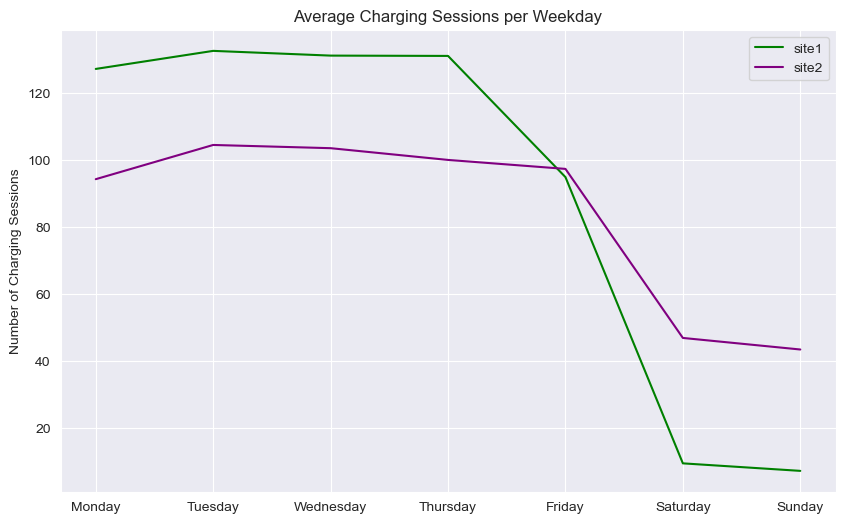

In [75]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
charging_data['day'] = pd.Categorical(charging_data['day'], categories=weekday_order, ordered=True)
charging_data['week'] = charging_data["connectionTime"].dt.isocalendar().week

# calculate number of charging sessions per week and day
sessions_per_week_weekday_site1 = charging_data[charging_data['siteID'] == '1'].groupby(['week', 'day'],
                                                                                        observed=False).size()
sessions_per_week_weekday_site2 = charging_data[charging_data['siteID'] == '2'].groupby(['week', 'day'],
                                                                                        observed=False).size()
# print(sessions_per_day_weekday_site1.head())

# calculate average number of charging sessions per weekday
average_sessions_per_weekday_site1 = sessions_per_week_weekday_site1.groupby('day', observed=False).mean()
average_sessions_per_weekday_site2 = sessions_per_week_weekday_site2.groupby('day', observed=False).mean()

plt.figure(figsize=(10, 6))
average_sessions_per_weekday_site1.plot(kind='line', label='site1', color='green')
average_sessions_per_weekday_site2.plot(kind='line', label='site2', color='purple')
plt.title('Average Charging Sessions per Weekday')
plt.xlabel(None)
plt.ylabel('Number of Charging Sessions')
plt.legend(loc=0)
plt.grid(True)
plt.show()

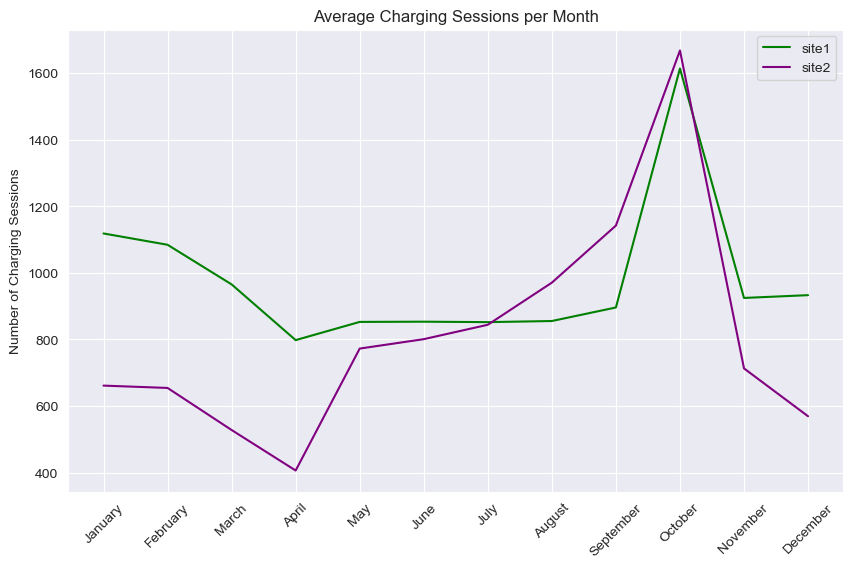

In [76]:
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October',
                'November', 'December']
charging_data['month'] = pd.Categorical(charging_data['connectionTime'].dt.month_name(), categories=months_order,
                                        ordered=True)
charging_data['year'] = charging_data['connectionTime'].dt.year

# calculate number of charging sessions per day and day of the week
sessions_per_year_month_site1 = charging_data[charging_data['siteID'] == '1'].groupby(['year', 'month'],
                                                                                      observed=True).size()
sessions_per_year_month_site2 = charging_data[charging_data['siteID'] == '2'].groupby(['year', 'month'],
                                                                                      observed=True).size()
# print(sessions_per_year_month_site1)

# calculate average number of charging sessions per day of the week
average_sessions_per_month_site1 = sessions_per_year_month_site1.groupby('month', observed=False).mean()
average_sessions_per_month_site2 = sessions_per_year_month_site2.groupby('month', observed=False).mean()

plt.figure(figsize=(10, 6))
average_sessions_per_month_site1.plot(kind='line', label='site1', color='green')
average_sessions_per_month_site2.plot(kind='line', label='site2', color='purple')
plt.title('Average Charging Sessions per Month')
plt.xlabel(None)
plt.ylabel('Number of Charging Sessions')
plt.legend(loc=0)
plt.xticks(range(0, 12), months_order, rotation=45)
plt.grid(True)
plt.show()

## 3 Utilization Prediction
### Data Preparation

In [77]:
def aggregate_charging_data(df, start_date, end_date):
    # Erstellen einer Liste aller Stunden im Datumsbereich
    all_hours = pd.date_range(start=start_date, end=end_date, freq='h')
    # Erstellen eines leeren DataFrames für die aggregierten Daten
    aggregated_df = pd.DataFrame(index=all_hours)
    aggregated_df.index.name = 'start_hour'

    total_hourly_chargingDuration = [0] * len(all_hours)
    total_hourly_connectionDuration = [0] * len(all_hours)
    total_numberOfSpaces = 0
    # Iterieren über die Standorte
    for site_id in df['siteID'].unique():
        site_df = df[df['siteID'] == site_id].copy()
        numberOfSpaces = len(site_df['spaceID'].unique())
        total_numberOfSpaces += numberOfSpaces
        
        hourly_activeSessions = []
        hourly_utilizationRate = []
        hourly_kwhDelivered = []
        hourly_idleRate = []
        hourly_blockedRate = []
        for index, hour in enumerate(all_hours):
            start_of_hour = hour
            end_of_hour = hour + pd.Timedelta(hours=1)
            # Alle chargingSessions, die in der Stunde aktiv waren
            #   folgende Edge-Cases werden aber mitgezählt!:
            #       Wenn eine session genau zum Anfang der Stunde beendet wurde oder
            #       Wenn eine session genau zum Ende der Stunde anfängt
            active_chargers = site_df[(site_df['connectionTime'] <= end_of_hour) & (site_df['disconnectTime'] >= start_of_hour)]
            hourly_activeSessions.append(len(active_chargers))
            
            total_kwh_in_hour = 0
            total_chargingDuration_in_hour = 0
            total_connectionDuration_in_hour = 0
            for _, charger in active_chargers.iterrows():
                # Wir wollen diverse Kennzahlen wie z.B. die kwhDelivered anteilig berechnen:
                #   daher nehmen wir entweder die connectionTime/ doneChargignTime oder start_hour - je nachdem was größer ist
                #   bei der disconnectTime/ doneChargingTime genauso nur umgekehrt
                connectionTime = max(charger['connectionTime'], start_of_hour)
                disconnectTime = min(charger['disconnectTime'], end_of_hour)
                doneChargingTime = min(charger['doneChargingTime'], end_of_hour)
                # Wie lange wurde in der einen Stunde tatsächlich geladen bzw. wie lange war man tatsächlich verbunden?
                chargingDuration_in_hour = (doneChargingTime - connectionTime).total_seconds() / 3600 #Dauer in Stunden
                connectionDuration_in_hour = (disconnectTime - connectionTime).total_seconds() / 3600 #Dauer in Stunden
                total_connectionDuration_in_hour += connectionDuration_in_hour
                
                # Edge Cases:   chargingSessions haben genau zum Ende der Stunde angefangen 
                #               bzw. zum Anfang der Stunde aufgehört
                #               ODER: chargingSessions befinden sich in idleTime
                if chargingDuration_in_hour > 0:
                    kwh_in_hour = (charger['kWhDelivered'] / 
                                   ((charger['doneChargingTime'] - charger['connectionTime']).total_seconds() / 3600)) * chargingDuration_in_hour
                    total_kwh_in_hour += kwh_in_hour
                    total_chargingDuration_in_hour += chargingDuration_in_hour

            # Berechnung der Kennzahlen
            hourly_kwhDelivered.append(total_kwh_in_hour)
            # hourly_utilizationRate.append(total_chargingDuration_in_hour / numberOfSpaces)
            hourly_utilizationRate.append(total_connectionDuration_in_hour / numberOfSpaces)
            total_hourly_chargingDuration[index] += total_chargingDuration_in_hour
            total_hourly_connectionDuration[index] += total_connectionDuration_in_hour
            if total_connectionDuration_in_hour > 0:
                hourly_idleRate.append(total_chargingDuration_in_hour / total_connectionDuration_in_hour)
                hourly_blockedRate.append((total_connectionDuration_in_hour - total_chargingDuration_in_hour) / numberOfSpaces)
            else:
                hourly_idleRate.append(0)
                hourly_blockedRate.append(0)
                

        aggregated_df[f'activeSessions_site{site_id}'] = hourly_activeSessions
        aggregated_df[f'utilizationRate_site{site_id}'] = hourly_utilizationRate
        aggregated_df[f'kWhDelivered_site{site_id}'] = hourly_kwhDelivered
        aggregated_df[f'idleRate_site{site_id}'] = hourly_idleRate
        aggregated_df[f'blockedRate_site{site_id}'] = hourly_blockedRate

    aggregated_df.fillna(0, inplace=True)
    aggregated_df['activeSessions_total'] = aggregated_df['activeSessions_site1'] + aggregated_df['activeSessions_site2']
    aggregated_df['kWhDelivered_total'] = aggregated_df['kWhDelivered_site1'] + aggregated_df['kWhDelivered_site2']
    # aggregated_df['utilizationRate_total'] = np.array(total_hourly_chargingDuration) / total_numberOfSpaces
    aggregated_df['utilizationRate_total'] = np.array(total_hourly_connectionDuration) / total_numberOfSpaces
    aggregated_df['idleRate_total'] = np.divide(
        total_hourly_chargingDuration,
        total_hourly_connectionDuration,
        out=np.zeros_like(total_hourly_chargingDuration, dtype=float), # wichtig für korrekten Datentyp
        where=np.array(total_hourly_connectionDuration) != 0
    )
    aggregated_df['blockedRate_total'] = (np.array(total_hourly_connectionDuration) - np.array(total_hourly_chargingDuration)) / total_numberOfSpaces
    return aggregated_df

In [78]:
# aggregated_data = aggregate_charging_data(charging_data, charging_data['connectionTime'].min().floor('h'),
#                                           charging_data['disconnectTime'].max().ceil('h'))
aggregated_data = aggregate_charging_data(charging_data, pd.to_datetime('2019-12-28').tz_localize('America/Los_Angeles'),
                                          pd.to_datetime('2019-12-29').tz_localize('America/Los_Angeles'))

# Hinzufügen der Zeitspalten
aggregated_data['hour_of_day'] = aggregated_data.index.hour
aggregated_data['week_of_year'] = aggregated_data.index.isocalendar().week
aggregated_data['day_of_week'] = aggregated_data.index.dayofweek  # 0=Montag, 6=Sonntag
aggregated_data['month_of_year'] = aggregated_data.index.month
aggregated_data['is_weekend'] = aggregated_data.index.dayofweek >= 5  # Samstag (5) oder Sonntag (6)
aggregated_data['date'] = aggregated_data.index.date
aggregated_data.head()

,activeSessions_site1,utilizationRate_site1,kWhDelivered_site1,idleRate_site1,blockedRate_site1,activeSessions_site2,utilizationRate_site2,kWhDelivered_site2,idleRate_site2,blockedRate_site2,...,kWhDelivered_total,utilizationRate_total,idleRate_total,blockedRate_total,hour_of_day,week_of_year,day_of_week,month_of_year,is_weekend,date
start_hour,,,,,,,,,,,,,,,,,,,,,
2019-12-28 00:00:00-08:00,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,52,5,12,True,2019-12-28
2019-12-28 01:00:00-08:00,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,52,5,12,True,2019-12-28
2019-12-28 02:00:00-08:00,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2,52,5,12,True,2019-12-28
2019-12-28 03:00:00-08:00,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3,52,5,12,True,2019-12-28
2019-12-28 04:00:00-08:00,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4,52,5,12,True,2019-12-28


In [79]:
# die Wetterdaten werden immer um 7:53h, 8:53h etc. geliefert -> wir runden also auf die nächste Stunde auf
def round_timestamp(timestamp):
    try:
        # Versuchen, den Zeitstempel zu runden
        return timestamp.round('h')
    except:
#       ... das klappt allerdings nicht immer aufgrund der Sommer-Zeitumstellungen
#           -> in dem Fall lassen wir den timestamp einfach so wie er ist
        return timestamp

def merge_with_weather_data(agg_data, weather):
    weather_data = weather.copy()
    aggregated_data = agg_data.copy()
    weather_data['timestamp'] = weather_data['timestamp'].apply(round_timestamp)
    # auf stündliche Daten reduzieren (falls irgendwo mehrere Aufzeichnungen pro Stunde geliefert werden)
    weather_data = weather_data.set_index('timestamp').resample('h').first().reset_index()
    weather_data = weather_data.rename(columns={'timestamp': 'start_hour'})
    
    aggregated_data = pd.merge(aggregated_data, weather_data, on='start_hour', how='left')
    aggregated_data.drop(columns=['city', 'felt_temperature', 'weather_date'], inplace=True)
    return aggregated_data

aggregated_data = merge_with_weather_data(aggregated_data, weather_data)
aggregated_data.columns

Index(['start_hour', 'activeSessions_site1', 'utilizationRate_site1',
       'kWhDelivered_site1', 'idleRate_site1', 'blockedRate_site1',
       'activeSessions_site2', 'utilizationRate_site2', 'kWhDelivered_site2',
       'idleRate_site2', 'blockedRate_site2', 'activeSessions_total',
       'kWhDelivered_total', 'utilizationRate_total', 'idleRate_total',
       'blockedRate_total', 'hour_of_day', 'week_of_year', 'day_of_week',
       'month_of_year', 'is_weekend', 'date', 'temperature', 'cloud_cover',
       'cloud_cover_description', 'pressure', 'windspeed', 'precipitation'],
      dtype='object')

### Descriptive Analysis

In [80]:
# Just for visual purpose
plt.figure(figsize=(8, 4))
namex = 'temperature'
# namey = 'activeSessions_site2'
namey = 'kwhDelivered_site2'
plt.scatter(aggregated_data[namex], aggregated_data[namey], c='blue', alpha=0.5)
# plt.title("Scatter connection_duration über connectionTime")
plt.xlabel(namex)
plt.ylabel(namey)
plt.grid(True)

KeyError: 'kwhDelivered_site2'

<Figure size 800x400 with 0 Axes>

### Training Models

In [68]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(aggregated_data, test_size=0.3)
print(len(train_data), len(test_data))

17 8


In [69]:
train_data.columns

Index(['start_hour', 'activeSessions_site1', 'utilizationRate_site1',
       'kwhDelivered_site1', 'idleRate_site1', 'blockedRate_site1',
       'activeSessions_site2', 'utilizationRate_site2', 'kwhDelivered_site2',
       'idleRate_site2', 'blockedRate_site2', 'activeSessions_total',
       'kwhDelivered_total', 'utilizationRate_total', 'idleRate_total',
       'blockedRate_total', 'hour_of_day', 'week_of_year', 'day_of_week',
       'month_of_year', 'is_weekend', 'date', 'temperature', 'cloud_cover',
       'cloud_cover_description', 'pressure', 'windspeed', 'precipitation'],
      dtype='object')

In [70]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Transform features
poly = PolynomialFeatures(degree=5, include_bias=False)
features = train_data['hour_of_day', 'week_of_year', 'day_of_week',
       'month_of_year', 'is_weekend', 'temperature',
       'cloud_cover', 'cloud_cover_description', 'pressure', 'windspeed',
       'precipitation']
target = train_data['activeSessions_site1']
X_poly = poly.fit_transform(features)

# Train model
model = LinearRegression()
model.fit(X_poly, target)

# Make predictions
X_test = test_data['hour_of_day', 'week_of_year', 'day_of_week',
       'month_of_year', 'is_weekend', 'temperature',
       'cloud_cover', 'cloud_cover_description', 'pressure', 'windspeed',
       'precipitation']
X_test_poly = poly.transform(X_test)
y_pred = model.predict(X_test_poly)

# # Evaluate model
# mse = mean_squared_error(target, model.predict(X_poly))
# print(f"Mean Squared Error: {mse}")

# Visualize results
plt.scatter(features, target, label='Original Data')
plt.plot(X_test, y_pred, color='red', label='Polynomial Regression')
plt.legend()
plt.show()

KeyError: ('hour_of_day', 'week_of_year', 'day_of_week', 'month_of_year', 'is_weekend', 'temperature', 'cloud_cover', 'cloud_cover_description', 'pressure', 'windspeed', 'precipitation')